## Exploring the Voynich Manuscript Via NLP Data Analysis
By Bobby Becker

Github Pages: https://nbviewer.org/github/ogreowl/voynich-analysis/blob/main/ms1.ipynb


**Project Overview**

This project will analyze the Voynich Manuscript, a mysterious document written in an unknown language that dates back to the 15th century. The characters and words have never been seen before on any other document, which makes the task of decoding it a particularly challenging one—one which has attracted the attention of world-famous cryptographers, historians, and other people with various fields of expertise.

For this class, I’d want to analyze this document using standard tools in natural language processing—such as Word2Vec models and Recurrent Neural Networks—along with some cutting-edge tools that have been developed over the past couple of years, such as BERT. I’ll also be using standard data analysis tools to measure and visualize characteristics, such as the distribution of words/characters.

**Project Data**

There are many different transliterations of the Voynich manuscript, which are simply mappings of the characters in the manuscript to characters in other languages used to represent them. These are normally text files, and they allow us to represent the characters, words, and the order of words in a way that can easily be computationally analyzed. For this project, I’ll be using the Glen Claston transliteration (they are all roughly the same, but this one just seemed the simplest and is stored in a plain .txt file, which is the easiest file format to work with.)

A 2016 paper found that the distributions of words in the Voynich manuscript mapped pretty closely onto the words in the Hebrew language. With that in mind, I’ll also be using a dataset of the Hebrew language with the intention of using new pattern recognition tools (like BERT) to compare patterns in that language with the patterns in the Voynich manuscript. I’ll also be using embeddings of words in the English language, as that’s my first language, and it gives me a good reference point for this analysis.

**Milestone 1 Progress**

So far, for my first milestone, I have:

*   Imported and cleaned the primary dataset Voynich manuscript .txt file
*   Visualized the distribution of the most commons characters and words
*   Used BERT to create embeddings for characters/words in the Voynich manuscript
*   Ran PCA, T-SNE, and UMAP on those embeddings to explore their relations
*   Created a function to measure the cosine-similarity between Voynich words & English words

**Plans for Milestone 2 and beyond:**

At this point, no exciting patterns have been identified, but I’ve set up the tools and the environment necessary for the project to do a deeper analysis. By Milestone 2, I’d want to expand my analysis with these tools in a more robust and rigorous way—trying many different parameters, models, and techniques to find patterns. To do this successfully, I’ll likely need to focus in on 10-15 different words and characters and around 5 different sentences to try to derive some meaningful patterns. I’ll also find, clean, and load in a dataset of Hebrew words, which I’ll embed with the same BERT model to compare to the embeddings of the Voynich words. Finally, I’ll create a simple unsupervised deep learning model to further analyze the contextual embeddings of Voynich words as they relate to the embeddings of Hebrew and English words.

Since many people much smarter than me have tried and failed to decode this manuscript, that would likely be an unfeasible goal. However, I can illustrate how modern tools in NLP can be used to uncover complex patterns that can give insight to documents like this. Ideally, I may even discover some meaningful patterns that contribute to the wider efforts to decode this manuscript.


**Sources:**

https://en.wikipedia.org/wiki/Voynich_manuscript

https://www.voynich.nu/origin.html#n04

https://www.tensorflow.org/text/tutorials/word2vec

https://arxiv.org/abs/1810.04805

https://www.voynich.nu/extra/sta.html#stalinks

https://ciphermysteries.com/2009/03/18/glen-claston-on-the-voynich-manuscript

https://transacl.org/ojs/index.php/tacl/article/view/821/174


First,this code will let me upload the Voynich manuscript file from my desktop into my Google Collab.
Since my dataset is relatively small, this is the simplest solution.
The Dataset is a .txt file downloaded from https://www.voynich.nu/transcr.html. It is a transliteration of the Voynich characters onto English characters, seperated by commas and periods to represent breaks between words.

In [2]:
from google.colab import files

uploaded = files.upload()

# This allows me to drag and drop my file into the dataset. 
for filename in uploaded.keys():
    print(f'Uploaded file: {filename}')

Saving data_cleaned.txt to data_cleaned.txt
Uploaded file: data_cleaned.txt


 Then, I'll call that file I just uploaded and clean it so it's very simple to analyze
After running these functions, the data is simply a series of characters seperated by commas—exactlywhat NLP tools are optimized for analyzing

In [3]:
import re
file_path = 'data_cleaned.txt'

with open(file_path, 'r', encoding='utf-8') as file:
    content = file.read()

characters = [char for char in content if char not in [',', '.']]

words = re.split(r'[,\s]+', content.strip())
words = [word for word in words if word]

For our first statistic, let's look at the total number of unique character and words. This will show us the size of the alphabet and dictionary that the Voynich manuscript contains, which is important because it tells us the discrete number of symbols that we have to analyze.

In [4]:
unique_characters = set(characters) # characters are set to be each indiviudal characters
unique_words = set(words) # words are set to be sets of characters seperated by spaces

print(f"Total Unique Characters: {len(unique_characters)}")
print(f"Total Unique Words: {len(unique_words)}")

Total Unique Characters: 75
Total Unique Words: 6339


75 characters—about three times as many as the English alphabet. This shows that there are quite a few different symbols in this language compared to modern day languages. 

And around 6339 words—intutively, this is around the amount of unique words that would be in a ~100-page document in the English language. 

Here, we'll how often every letter is shown. With this statistic, we can see how often the most common letters come up compared to the least common letters. 

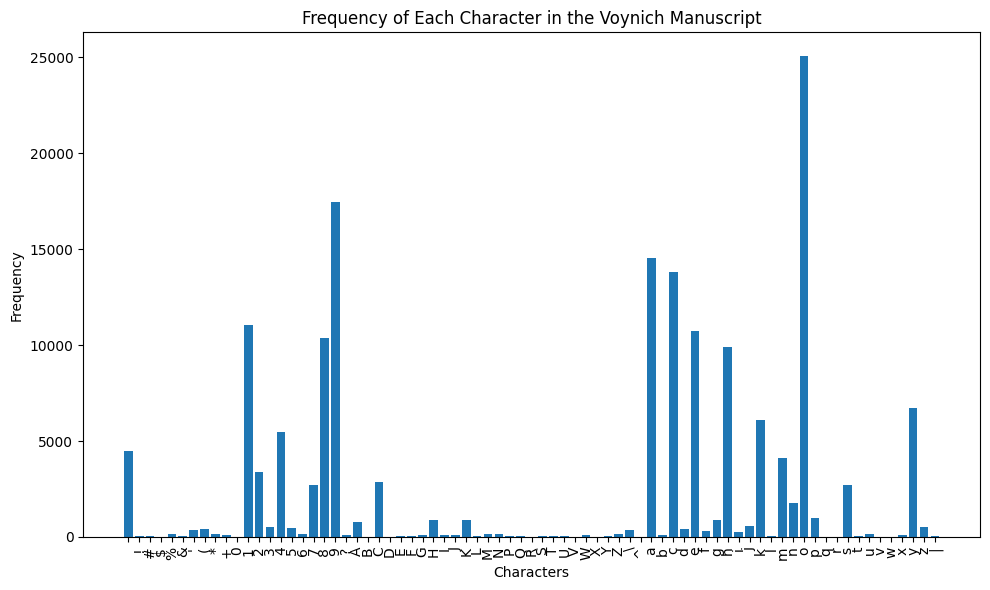

In [5]:
import matplotlib.pyplot as plt
from collections import Counter

# Count the frequency of each character
character_counts = Counter(characters)

# Sort the character counts by character
sorted_characters = sorted(character_counts.items())

# Unpack the characters and their frequencies
chars, freqs = zip(*sorted_characters)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(chars, freqs)
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.title('Frequency of Each Character in the Voynich Manuscript')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to avoid label cutoff

# Display the plot
plt.show()

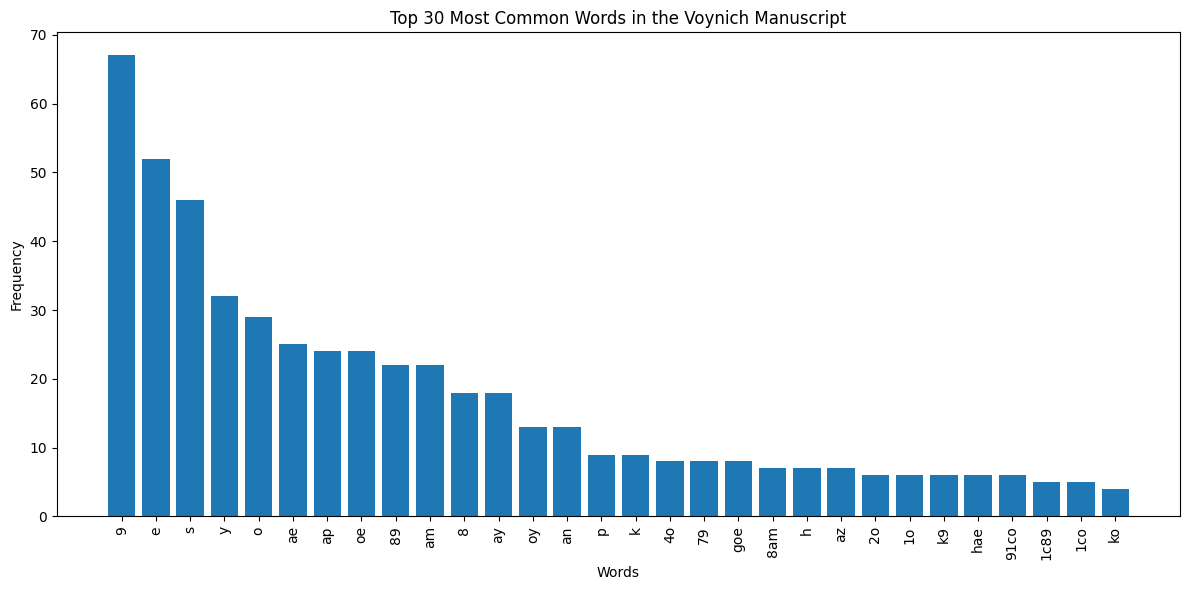

In [6]:
# Now, let's do the frequency of the 30 most common words:

word_counts = Counter(words)
most_common_words = word_counts.most_common(30)
common_words, common_freqs = zip(*most_common_words)

plt.figure(figsize=(12, 6))
plt.bar(common_words, common_freqs)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Most Common Words in the Voynich Manuscript')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Seems like a graphic that follows the distribution of words in other natural languages as well—a good sign that the voynich manuscript isn't just nonsense, but has real meaning that we just haven't been able to decode yet. 

**Natural Language Processing Analysis**


First, here, we'll kick off the simplest (but very effective) tool from NLP. We'll train a Word2Vec model from the dataset, which will get us a vector embedding of each unique token (which are words, in this case)


The vectors have a mathematical relation to each other. For example, in English, the vector embedding of 'Man' added to the vector embedding of 'Queen' minus the vector embedding of 'Women' would yield a vector embedding most similar to
'King.' This is how semantic meaning is mathematically encoded. If the Voynich manuscript has semantic meaning, these types of relationships should exist in this text as well.

In [7]:
import re
from gensim.models import Word2Vec #importing a common ML library

def custom_tokenizer(text):
    tokens = re.split(r'[,.]', text)
    tokens = [token.strip() for token in tokens if token.strip()]
    return tokens # Here, we tokenize the words to prepare to feed into the model. 

sentences = [] # We'll treat lines as sentences
for line in content.splitlines():
    tokens = custom_tokenizer(line)
    if tokens:  # Only add non-empty sentences
        sentences.append(tokens)

model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=0) # Create model of vector size 100 (each word as 100 numbers to represent its meaning)

model.save("voynich_word2vec.model") # Saving model to use later

if 'example_word' in model.wv:
    print(model.wv['example_word'])

In [8]:
# Now, we can find which words are most similar to any word that we put in.
similar_words = model.wv.most_similar('9', topn=10)
print(similar_words)

[('am', 0.9997212290763855), ('89', 0.99972003698349), ('8ay', 0.9996842741966248), ('ay', 0.9996780157089233), ('ae', 0.999660849571228), ('1c9', 0.9996318817138672), ('8am', 0.9996185302734375), ('okam', 0.9996150135993958), ('o', 0.9996011853218079), ('e', 0.9995999336242676)]


In [12]:
pip install umap-learn
# Just one requirement here that we need that isn't in the Google Collab default packages

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.7 MB/s eta 0:00:00


To visualize the relation between words created by the Word2Vec vectors, we'll use Principle Component analysis, t-SNE, and UMAP, which are all methods for reducing the data to lower dimensions.

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


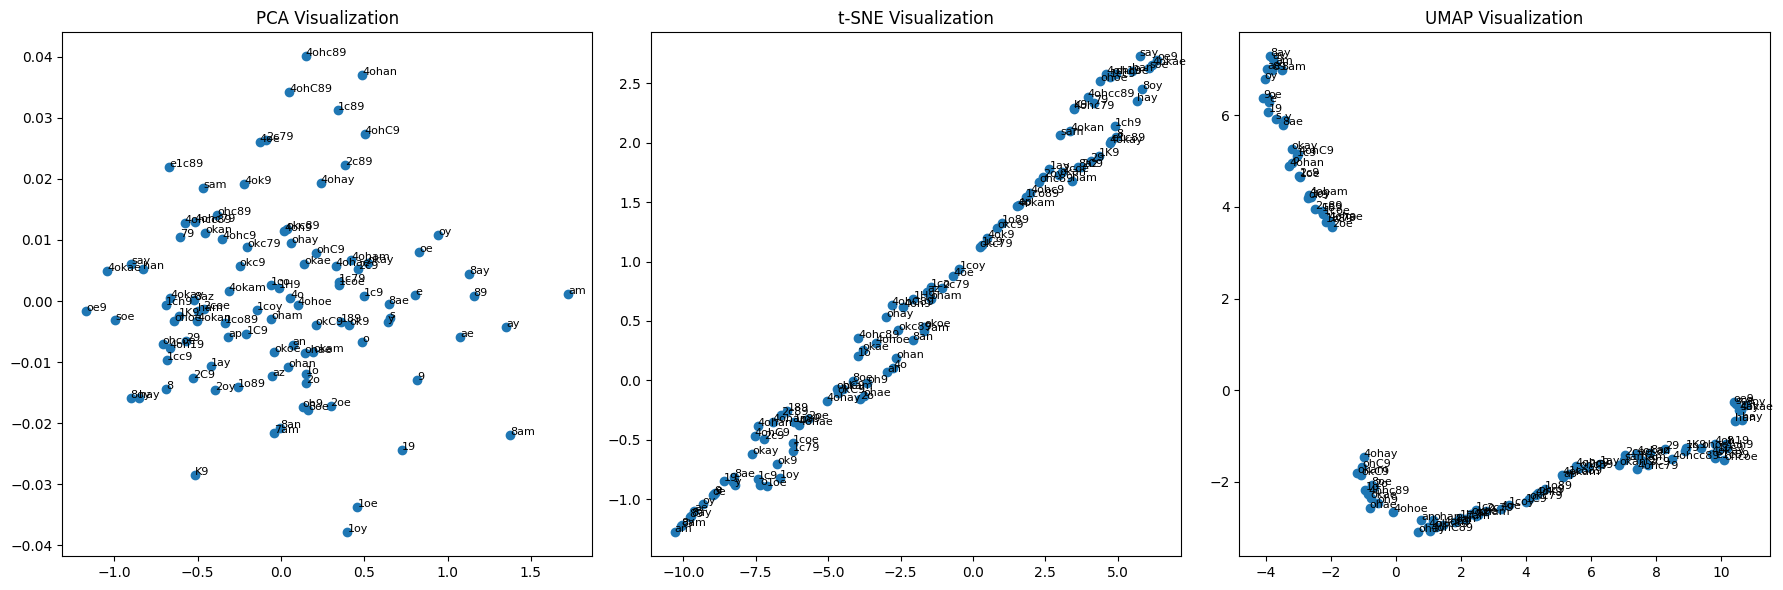

In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
import matplotlib.pyplot as plt

# First, we retrieve word vectors from the model for a subset of words
words = list(model.wv.index_to_key[:100])  # Limiting to first 100 words for simplicity
word_vectors = model.wv[words]

# PCA (Linear Dimensionality Reduction)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(word_vectors)

# t-SNE (Non-linear Dimensionality Reduction)
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
tsne_result = tsne.fit_transform(word_vectors)

# UMAP (Non-linear Dimensionality Reduction)
umap_model = umap.UMAP(n_components=2)
umap_result = umap_model.fit_transform(word_vectors)


plt.figure(figsize=(18, 6))

# PCA Plot
plt.subplot(1, 3, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, (pca_result[i, 0], pca_result[i, 1]), fontsize=8)
plt.title('PCA Visualization')

# t-SNE Plot
plt.subplot(1, 3, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, (tsne_result[i, 0], tsne_result[i, 1]), fontsize=8)
plt.title('t-SNE Visualization')

# UMAP Plot
plt.subplot(1, 3, 3)
plt.scatter(umap_result[:, 0], umap_result[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, (umap_result[i, 0], umap_result[i, 1]), fontsize=8)
plt.title('UMAP Visualization')

plt.tight_layout()
plt.show()

Pretty cool! The first plot shows how the different words compare to each other when reduced to 2 dimensions in the most straight-forward way. The second plot reduces to 2 dimensions with a specialized algorithm that keeps track of local relations; this tells us that words next to each other on that plot are highly likely to be synonymous. UMAP focuses on global relations: it splits the words into two groups, which hints that there may be two main types of words in this language (like, verb-ish words and noun-ish words, for example)

In [14]:
# Here, we first have to tokenize the words, which basically means we'll prepare their format to something that BERT can interpret

from transformers import BertTokenizerFast
from tokenizers import BertWordPieceTokenizer


with open("voynich_vocab.txt", "w") as vocab_file:
    for word in set(words):
        vocab_file.write(f"{word}\n")

tokenizer = BertWordPieceTokenizer(lowercase=False)

tokenizer.train(files=["voynich_vocab.txt"], vocab_size=6339)
import os

os.makedirs("voynich_tokenizer", exist_ok=True)
tokenizer.save_model("voynich_tokenizer")
custom_tokenizer = BertTokenizerFast.from_pretrained("voynich_tokenizer")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [15]:
# Then, we join the tokenized words back together, which makes the data completely prepared
words_text = ' '.join(words)

encoded_inputs = custom_tokenizer(
    words_text, padding=True, truncation=True, return_tensors="pt", max_length=128
)

input_ids = encoded_inputs['input_ids']
attention_mask = encoded_inputs['attention_mask']

print(f"Input IDs shape: {input_ids.shape}")
print(f"Attention Mask shape: {attention_mask.shape}")

Input IDs shape: torch.Size([1, 128])
Attention Mask shape: torch.Size([1, 128])


In [16]:
# Here, we'll use Torch to train the model from scratch, as this is an entirely new language.
# Our initial BERT configuration will use pretty standard parameters, but we'll probably have to experiment here to find out what works the best.
from transformers import BertConfig, BertForMaskedLM
import torch

config = BertConfig(
    vocab_size=6339,  # The size of your vocabulary (unique words)
    hidden_size=768,  # Size of hidden layers
    num_hidden_layers=12,  # Number of transformer layers
    num_attention_heads=12,  # Number of attention heads
    intermediate_size=3072,  # Feed-forward layer size
)

model = BertForMaskedLM(config)

# Use AdamW optimizer for training
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
model.train()

# Train for 8 epochs
for epoch in range(8):
    optimizer.zero_grad()
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
    loss = outputs.loss
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

Epoch 1, Loss: 8.9384126663208
Epoch 2, Loss: 7.453071117401123
Epoch 3, Loss: 6.673376560211182
Epoch 4, Loss: 6.092570781707764
Epoch 5, Loss: 5.402864933013916
Epoch 6, Loss: 4.742955207824707
Epoch 7, Loss: 4.055696964263916
Epoch 8, Loss: 3.5221939086914062


In [17]:
model.save_pretrained("voynich_bert_model")
custom_tokenizer.save_pretrained("voynich_tokenizer")

('voynich_tokenizer/tokenizer_config.json',
 'voynich_tokenizer/special_tokens_map.json',
 'voynich_tokenizer/vocab.txt',
 'voynich_tokenizer/added_tokens.json',
 'voynich_tokenizer/tokenizer.json')

In [18]:
# Now, for 100 words, we have a vector of size 768 to represent its semantic meaning.

encoded_inputs = custom_tokenizer(
    words, padding=True, truncation=True, return_tensors="pt", max_length=128
)

input_ids = encoded_inputs['input_ids']
attention_mask = encoded_inputs['attention_mask']

model.eval()
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)

hidden_states = outputs.hidden_states
last_hidden_state = hidden_states[-1]
word_embeddings = torch.mean(last_hidden_state, dim=1).numpy()
print(f"New Word embeddings shape: {word_embeddings.shape}")

New Word embeddings shape: (100, 768)


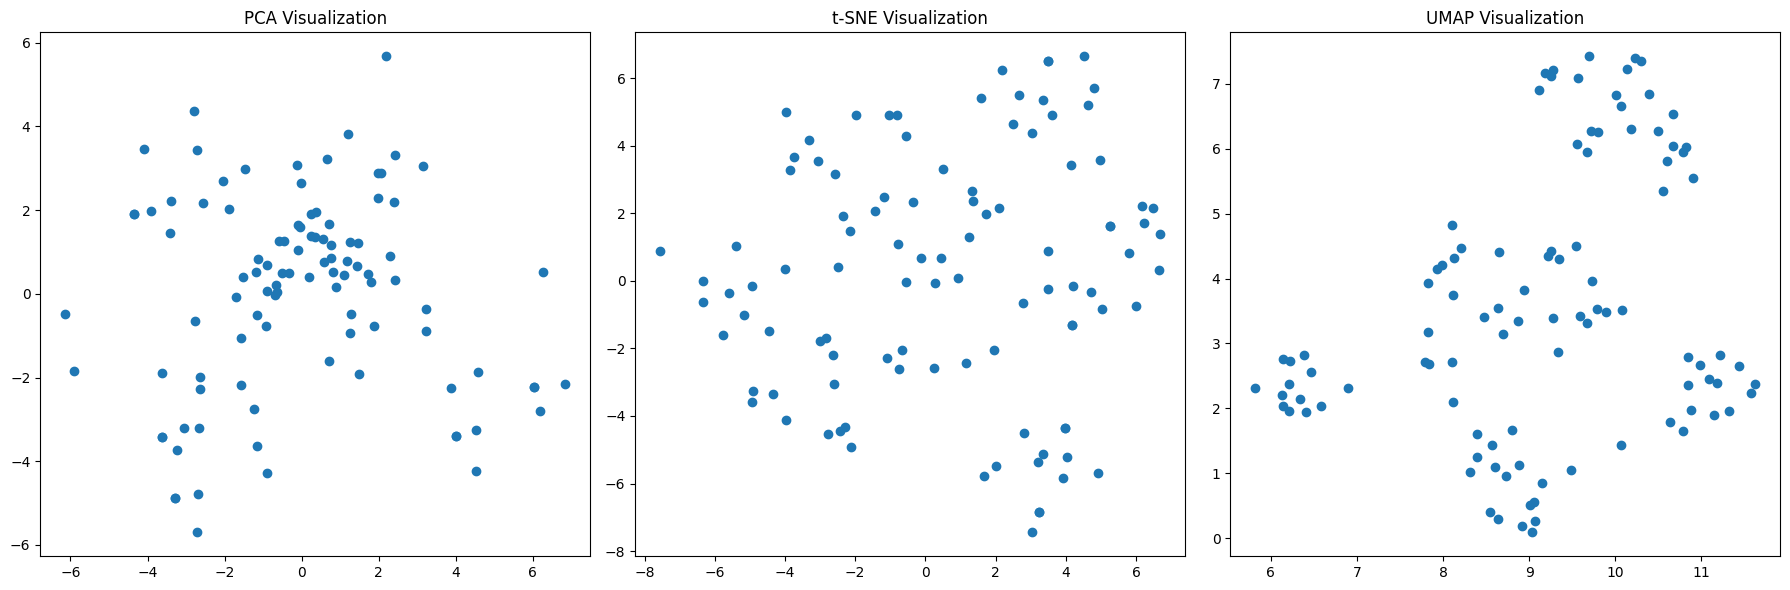

In [19]:
# Let's first compress these to 2D just to see what it looks like:

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
import matplotlib.pyplot as plt

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(word_embeddings)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000)
tsne_result = tsne.fit_transform(word_embeddings)

# UMAP
umap_model = umap.UMAP(n_components=2)
umap_result = umap_model.fit_transform(word_embeddings)

plt.figure(figsize=(18, 6))

# PCA Plot
plt.subplot(1, 3, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.title('PCA Visualization')

# t-SNE Plot
plt.subplot(1, 3, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
plt.title('t-SNE Visualization')

# UMAP Plot
plt.subplot(1, 3, 3)
plt.scatter(umap_result[:, 0], umap_result[:, 1])
plt.title('UMAP Visualization')

plt.tight_layout()
plt.show()


In [20]:
# Now, we'll compare those embeddings to the BERT embeddings of English words.
# For this, we'll use a pre-trained model, as English-language LLMs are very well developed.

from transformers import BertTokenizer, BertModel
import torch

pretrained_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
pretrained_model = BertModel.from_pretrained('bert-base-uncased')

common_english_words = [
    "the", "be", "to", "of", "and", "a", "in", "that", "have", "I", "it", "for", "not",
    "on", "with", "he", "as", "you", "do", "at", "this", "but", "his", "by", "from",
    "they", "we", "say", "her", "she", "or", "an", "will", "my", "one", "all", "would",
    "there", "their", "what", "so", "up", "out", "if", "about", "who", "get", "which",
    "go", "me", "when", "make", "can", "like", "time", "no", "just", "him", "know",
    "take", "people", "into", "year", "your", "good", "some", "could", "them", "see",
    "other", "than", "then", "now", "look", "only", "come", "its", "over", "think",
    "also", "back", "after", "use", "two", "how", "our", "work", "first", "well",
    "way", "even", "new", "want", "because", "any", "these", "give", "day", "most",
    "us"
]

# Tokenize the words
encoded_inputs = pretrained_tokenizer(common_english_words, padding=True, truncation=True, return_tensors="pt")

# Get the embeddings from the pre-trained BERT model
with torch.no_grad():
    outputs = pretrained_model(**encoded_inputs)
    english_word_embeddings = torch.mean(outputs.last_hidden_state, dim=1).numpy()  # Pooling

# Print the shape to confirm
print(f"English word embeddings shape: {english_word_embeddings.shape}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

English word embeddings shape: (100, 768)


In [21]:
# Using a dictionary (as above) turned out to be too tedious. So we'll actually just access a dictionary using nltk to get the top 500 most common
# English words.
import nltk
from nltk.corpus import brown
from collections import Counter

# Download the Brown corpus (if you haven't already)
nltk.download('brown')

# Get words from the Brown corpus (a large body of English text)
words_in_brown = brown.words()

# Calculate word frequencies
word_freq = Counter(words_in_brown)

# Get the 500 most common words
common_english_words = [word.lower() for word, _ in word_freq.most_common(100)]

# Print the first few words
print(f"The 500 most common English words: {common_english_words[:10]}")

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


The 500 most common English words: ['the', ',', '.', 'of', 'and', 'to', 'a', 'in', 'that', 'is']


In [22]:
# Now we create vector representations of them using BERT
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT model and tokenizer
pretrained_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
pretrained_model = BertModel.from_pretrained('bert-base-uncased')

# Tokenize the 500 most common English words using the pre-trained tokenizer
encoded_inputs = pretrained_tokenizer(common_english_words, padding=True, truncation=True, return_tensors="pt")

# Get the embeddings from the pre-trained BERT model
with torch.no_grad():
    outputs = pretrained_model(**encoded_inputs)
    english_word_embeddings = torch.mean(outputs.last_hidden_state, dim=1).numpy()  # Pooling

# Print shape to confirm
print(f"English word embeddings shape: {english_word_embeddings.shape}")


English word embeddings shape: (100, 768)


In [23]:
# And now, we can create a function that takes in a Voynich word (embedded with BERT), finds the English words with the most similar embeddings,
# and displays them. Ideally, if a Voynich word means 'plant', it could have a close cosine similarity to English words that mean 'plant.'
# We'll probably have to iterate this function to find any obvious pattern like that, however.

from sklearn.metrics.pairwise import cosine_similarity
import torch
import numpy as np

def get_most_similar_english_words(voynich_word):
    encoded_input = custom_tokenizer(voynich_word, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**encoded_input, output_hidden_states=True)  # Request hidden states
        last_hidden_state = outputs.hidden_states[-1]  # Last layer hidden state
        voynich_word_embedding = torch.mean(last_hidden_state, dim=1).numpy()

    # Compute cosine similarities between the Voynich word and all English word embeddings
    similarities = cosine_similarity(voynich_word_embedding, english_word_embeddings)

    top_10_indices = np.argsort(similarities[0])[-10:][::-1]
    top_10_english_words = [common_english_words[i] for i in top_10_indices]

    return top_10_english_words

voynich_word = input("Enter a Voynich word: ")
similar_words = get_most_similar_english_words(voynich_word)

# Output the top 10 most similar English words
print(f"Top 10 most similar English words to '{voynich_word}': {similar_words}")

Enter a Voynich word: 9
Top 10 most similar English words to '9': [':', 'that', 'will', 'had', ')', 'are', 'about', 'or', 'said', 'time']
